# Table of contents:

* [Pseudorandom number generators](#prng)
* [Linear congruential generators](#lcg)
* [Building a psedodrandom number generator](#prng2)
* [Better ways to generate pseudorandom numbers](#randnumb)
* [The quest for the perfect random generator](#perfectr)

    
Author: [Sebastià Agramunt Puig](https://github.com/sebastiaagramunt) for [OpenMined](https://www.openmined.org/) Privacy ML Series course.


# Pseudorandom number generators <a class="anchor" id="prng"></a>

In this section we will learn how to create "random" numbers using a computer. Why do we even need to generate random numbers in the context of cryptography?. Actually we constantly use random numbers in cryptography, e.g. to generate a completely random secret key. There's a quest in cryptography to generate purely random numbers. First, let's take inspiration from the one time pad to see why one would need random numbers

In [1]:
from random import randrange
import string

def vigenere_key_generator(secret_key_size: int) -> str:
    n = len(string.ascii_lowercase)
    secret_key = ''
    while len(secret_key) < secret_key_size:
        secret_key += string.ascii_lowercase[randrange(n)]
    return secret_key

def shift_letter(letter: str, shiftby: str, forward: bool=True) -> str:
    n = len(string.ascii_lowercase)
    
    letter_int = ord(letter) - 97
    shiftby_int = ord(shiftby) - 97
    
    if forward:
        return string.ascii_lowercase[(letter_int+shiftby_int)%n]
    else:
        return string.ascii_lowercase[(letter_int-shiftby_int)%n]
    
def vigenere_encrypt_decrypt(message: str, secret_key: str, encrypt:bool = True) -> str:
    key_len = len(secret_key)
    
    encoded = ''
    for i, letter in enumerate(message):
        if letter != " ":
            encoded += shift_letter(letter, secret_key[i%key_len], forward=encrypt)
        else:
            encoded += letter
    return encoded

In [2]:
message = "helloworld"
secret_key = vigenere_key_generator(len(message))
ciphertext = vigenere_encrypt_decrypt(message, secret_key, encrypt=True)

print(f"message = {message}\nsecret_key = {secret_key}\nciphertext = {ciphertext}")

message = helloworld
secret_key = wezaqvkmpb
ciphertext = diklerydae


The one time pad in bits:

In [3]:
from random import randrange

message = "01011101000101110101"
secret_key = ''.join([str(randrange(2)) for _ in range(len(message))])
ciphertext = ''.join([str((int(m)+int(s))%2) for m, s in zip(message, secret_key)])

In [4]:
print(f"message:\n\t{message}")
print(f"secret_key\n\t{secret_key}")
print(f"ciphertext\n\t{ciphertext}")

message:
	01011101000101110101
secret_key
	00010011111001000100
ciphertext
	01001110111100110001


If the secret_key is a sequence known by Alice and Bob and generated completely random, then the cryptosystem is perfectly secret. Problems for one time pad?

* key lenght has to be at least the same as message lenght
* the key has to be completely random 
* Alice and Bob have to meet each time to exchange the secret key

Let's design a system very close to pure random:

# Linear congruential generators <a class="anchor" id="lcg"></a>

A linear congruential generator (LCG) is an algorithm that yields a sequence of pseudo-randomized numbers calculated with a discontinuous piecewise linear equation.

$$X_{n+1}=X_n*a+c \textrm{ (mod m)}$$.

There are several LCGs, in the example we take the one of numerical recipes correspoding to the values: a = 1664525, c = 1013904223 and m = $2^{32}$. The initial value $X_0$ is called the seed of the pseudoradom generator.

In [5]:
a = 1664525
c = 1013904223
m = 2**32

def lcg(x0: int, a: int, c: int, m: int) -> int:
    return (x0*a+c)%m

In [6]:
x0 = 433

l = []

xn = x0
for _ in range(100000):
    xn = lcg(xn, a, c, m)
    l.append(xn/m)

<Figure size 432x288 with 0 Axes>

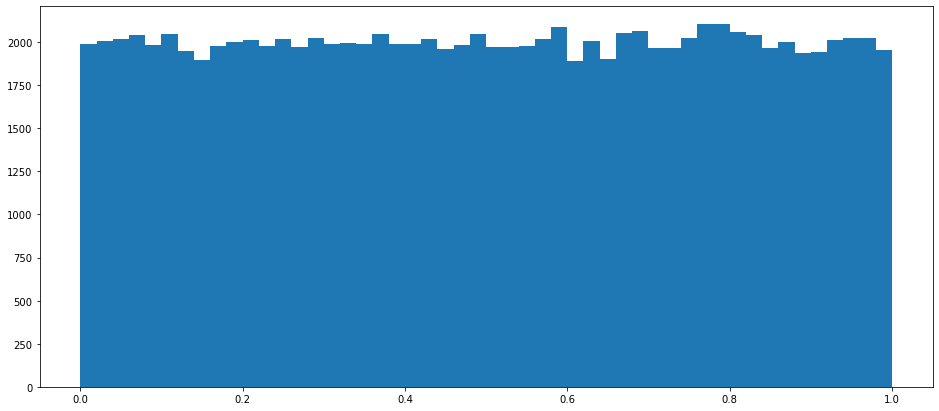

In [7]:
import matplotlib.pyplot as plt

plt.clf()
fig = plt.figure(figsize=(16,7))
plt.hist(l, bins=50)
plt.show()

The good thing about pseudorandom generators is that you can reconstruct the pseudorandom numbers taking the same initial seed

In [8]:
x0 = 53

xn = x0
for _ in range(10):
    xn = lcg(xn, a, c, m)
    print(xn)

1102124048
368793647
468461506
2704688185
3035635780
1075818195
810411542
842425981
2017260984
2691087799


In [9]:
x0 = 53

xn = x0
for _ in range(10):
    xn = lcg(xn, a, c, m)
    print(xn)

1102124048
368793647
468461506
2704688185
3035635780
1075818195
810411542
842425981
2017260984
2691087799


This can be useful!. Alice and Bob can generate the same randomness if they keep the seed as a secret!. The secret is the Diffie-Hellman key they generated.

# Building PRNG function <a class="anchor" id="prgn2"></a>

We will use the common function ```randrange``` from random to create a binary pseudorandom generator.

In [10]:
from random import seed

def PRNG(s: int, l: int) -> list:
    seed(s)
    
    prng = []
    while len(prng) < l:
        prng.append(randrange(2))
    return ''.join([str(n) for n in prng])

In [11]:
s = 134323

# Alice's end
prng_alice = PRNG(s, 10)

# Bob's end
prng_bob = PRNG(s, 10)

print(prng_alice)
print(prng_bob)

0110011011
0110011011


# Better ways to generate random numbers in the computer <a class="anchor" id="randnumb"></a>

Our PRNG uses a seed as the source for the entropy for the random numbers. We can use **other seeds like environmental computer noise** (frequency of typing, temperature variation...). 

Using your system ```/dev/urandom```, e.g generate 10 random bytes (using MacOS). Open a terminal and run:

```head -c 10 /dev/urandom```

to see the output.

In [12]:
# calling the urandom function
import subprocess

command = "head -c 10 /dev/urandom"
process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
output, error = process.communicate()

print(f"Random bytes:\n\t{output}")

Random bytes:
	b'\xeb/\xf3\x98O\xb8 \x81W\xac'


In [13]:
# transform to integer bytes
int_bytes = [b for b in output]

print(f"Random bytes:\n\t{output}\nconverted integers:\n\t{int_bytes}")

Random bytes:
	b'\xeb/\xf3\x98O\xb8 \x81W\xac'
converted integers:
	[235, 47, 243, 152, 79, 184, 32, 129, 87, 172]


In [14]:
# transform to integer
int.from_bytes(output, "big")

1110640673313030888576940

With the system random we can generate random bits of information. For instance:

In [15]:
# using secrets to acess the sytem random
import secrets

r = secrets.SystemRandom()
r.seed(23123)
bin(r.getrandbits(512))[2:]

'10000000001000110001111000001011100101110110111100111100011101000000100001101000000000011011000010100011000100101010100000001001001110000110011110011100010101100000011000110001010101010011010011101101110011000011001011001100001100111011100001110100111101101011000010100011000100001110000100000011010011110000000101111011101100100100001010101000100101000001000110101000111111110110111011111010100110100101101001101011000011110101101000111000111001110101110111001001111110111100111110100101010111011111100110010000'

## The quest for a perfect **random generator** <a class="anchor" id="perfectr"></a>

Using environmental computer noise is great as a source of entropy to generate random numbers, however the noise that Alice generates is differen than what Bob generates so they do not generate the same stream of bits. For now, we are forced to use pseudorandom generators based on a single seed, the secret key.

We need that:

* The probability to randomly generate each bit 1 or 0 is 0.5
* Alice and Bob generate the same exact stream of random bits

How can we do that?

Hopefully quantum physics comes to help. Quantum physics is intrinsecally random and therfore we can use it to generate purely random numbers. Also there are ways to correlate two systems (Alice and Bob) so that they generate the same stream of random numbers. This physics phenomenon is called [quantum entanglement](https://en.wikipedia.org/wiki/Quantum_entanglement) and is an active field of research in both experimental and theoretical physics.